# Scattering Rate Factor Analysis

There are many factors that go into calculating the rate the carriers transition into lower-energy states (i.e., scatter) around a defect. The calculations are very expensive, so determining the factors that contribute most to a high transition rate is paramount to narrowing the focus to only states that are likely to meaningfully contribute.

In [1]:
import numpy as np
import pandas as pd
import glob
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.decomposition import PCA

In [2]:
THzToHartree = 2.4188843265864e-5

## Read data

There are five sets of data that I am going to focus on for this analysis: the full energy table for all allowable transitions (indexed by initial and final state), the plotting-energy table with the energy of each state (eigenvalue and total energy) relative to the top of the valence band, the `Sj.out` files (one for each transition) holding the Huang-Rhys factors and frequencies for each mode, the table of overlaps and matrix elements (indexed by initial and final state), and the transition-rate output file with the rate of transition between each of the states. The full energy table is in Hartree, the plotting-energy table is in eV, $S_j$ is unitless, $\omega_j$ is the angular frequency in Hartree atomic units, the overlaps are unitless, the matrix elements are in Hartree$^2$, and the transition rate is in $1/s$. 

Start with the full energy table. `ibi` and `ibf` are the initial- and final-state band indices. There are several energies that go into the transition-rate calculation: `dEDelta` is the energy transferred to the phonons, `dEZeroth` and `dEFirst` are used in the calculation of matrix elements, `dEGroundInit` and `dEFinalGround` are small energy adjustments as the system adjusts to a carrier approaching/leaving the defect in the initial/final state. 

In [3]:
fullEnergyTable = pd.read_csv('FullEnergyTableByInitialFinalStates.csv')
fullEnergyTable.head()

,ibi,ibf,dEDelta,dEZeroth,dEFirst,dEGroundInit,dEFinalGround
0,1551,1553,-0.00188,-4.950000e-08,4.950000e-08,0.000998,-0.000903
1,1551,1554,-0.00265,-4.220000e-03,4.220000e-03,0.000998,-0.001010
2,1551,1555,-0.00347,-4.250000e-03,4.250000e-03,0.000998,-0.001130
3,1551,1557,-0.00406,-6.340000e-03,6.340000e-03,0.000998,-0.001070
4,1551,1568,-0.00708,-7.340000e-03,7.340000e-03,0.000998,-0.001130


For scattering, `dEFirst = -dEZeroth`, so let's drop `dEFirst` from the data frame.

In [4]:
fullEnergyTable = fullEnergyTable.drop(['dEFirst'], axis=1)
fullEnergyTable.head()

,ibi,ibf,dEDelta,dEZeroth,dEGroundInit,dEFinalGround
0,1551,1553,-0.00188,-4.950000e-08,0.000998,-0.000903
1,1551,1554,-0.00265,-4.220000e-03,0.000998,-0.001010
2,1551,1555,-0.00347,-4.250000e-03,0.000998,-0.001130
3,1551,1557,-0.00406,-6.340000e-03,0.000998,-0.001070
4,1551,1568,-0.00708,-7.340000e-03,0.000998,-0.001130


The plotting energy table has the eigenvalue difference and total-energy difference (including relaxation energy) from a reference point (in this case the top of the valence band).

In [5]:
plotEnergyTable = pd.read_csv('EnergyFromRefByInitialState.csv')
plotEnergyTable.head()

,ibi,EigDiffFromRef,TotEDiffFromRef
0,1551,-1.1680,1.1168
1,1552,-1.1680,1.1166
2,1553,-1.1680,1.0655
3,1554,-1.0532,1.0445
4,1555,-1.0522,1.0223


In [6]:
overlapsAndMEs = pd.read_csv('MatrixElementByInitialFinalStates.csv')
overlapsAndMEs.head()

,ibi,ibf,Norm2Overlap,MatrixElement
0,1551,1553,0.037000,9.040000e-17
1,1551,1554,0.004350,7.730000e-08
2,1551,1555,0.001540,2.790000e-08
3,1551,1557,0.002390,9.610000e-08
4,1551,1568,0.000118,6.360000e-09


In [21]:
transitionRates = pd.read_csv('TransitionRatesByInitialFinalStates.csv')
transitionRates.head()

,ibi,ibf,TransitionRate
0,1551,1553,3.310000e+03
1,1551,1554,2.770000e+12
2,1551,1555,3.280000e+11
3,1551,1557,3.890000e+11
4,1551,1568,3.850000e+10


Also read in the thermal occupation numbers $\bar{n}_j$ for each of the phonon modes (i.e., the average number of phonons or amount of energy in each one of the modes at a given temperature).

In [22]:
nj = np.genfromtxt('njThermal.csv', delimiter=',', skip_header=1, usecols=1)
nj[0:5]

array([2.18, 2.14, 2.1 , 2.06, 2.02])

The files with the Huang-Rhys factors are more complex to read. They are in a subfolder called `transitions` and each have the pattern `Sj.k1_b<ibi>.k1_b<ibf>.out`. The first 5 rows are headers, then there are 1077 more lines in each file for each of the phonon modes in our supercell. The first column is the mode index, the second column is the Huang-Rhys factor `Sj_if`, and the last column is the frequency `omegaj`. The rows are in order of decreasing `Sj_if`. `omegaj` does not depend on the transition, so we only need to read it once.

In [23]:
filePattern = "transitions/Sj.k1_b*.k1_b*.out"

# Initialize arrays
Sj_if = []
omegaj = None

# Iterate over all files in the folder matching the pattern
for filePath in glob.glob(filePattern):
    # Skip the first 5 lines and then read the fixed-width columns
    data = np.loadtxt(filePath, skiprows=5, max_rows=1077)
    
    # Sort the data by mode index so that the modes can be accessed
    # consistently later
    sortedData = data[np.argsort(data[:,0])]
    
    # Split the columns: first column is the mode index, second is Sj_if, third is omegaj
    Sj_if_in = sortedData[:,1]  # Second column is Sj_if
    omegaj_in = sortedData[:,2]*THzToHartree  # Third column is omegaj (same for all files)
    
    # Append Sj_if for the current file
    Sj_if.append(Sj_if_in)
    
    # Only store omegaj once (since it's the same across all files)
    if omegaj is None:
        omegaj = omegaj_in

# Convert to numpy arrays for easy manipulation later
Sj_if = np.array(Sj_if)
omegaj = np.array(omegaj)

print("Sj_if shape:", Sj_if.shape)
print("omegaj shape:", omegaj.shape)
Sj_if[0:3,0:3]

Sj_if shape: (1048, 1077)
omegaj shape: (1077,)


array([[0.00314327, 0.00155531, 0.000645  ],
       [0.00052669, 0.00049187, 0.00038955],
       [0.00123603, 0.00022475, 0.00019362]])

## Derive data from phonon features

There is so much data within the Huang-Rhys factors and frequencies, but I don't want to use all of it directly. Instead, I am going to generate some other measures that can be indexed by the initial and final states. 

First create a starter data frame with just the state indices (I have validated that the indices are in the same order).

In [24]:
SjDerived = pd.DataFrame({
    'ibi': transitionRates['ibi'],
    'ibf': transitionRates['ibf']
})
SjDerived.head()

,ibi,ibf
0,1551,1553
1,1551,1554
2,1551,1555
3,1551,1557
4,1551,1568


Add the maximum Huang-Rhys factor `Sj` across all modes for each transition.

In [25]:
SjDerived['maxSj_if'] = np.max(Sj_if, axis=1)
SjDerived.head()

,ibi,ibf,maxSj_if
0,1551,1553,0.228657
1,1551,1554,0.189230
2,1551,1555,0.060817
3,1551,1557,0.018728
4,1551,1568,0.369482


Add the count of `Sj` greater than different cutoffs along with the mean above and below the thresholds.

In [26]:
# Isolate the Sj above and below the threshold
aboveThresholdMask = Sj_if > 1e-2
belowThresholdMask = ~aboveThresholdMask

# Get count above and below
countAbove = np.sum(aboveThresholdMask, axis=1)
countBelow = np.sum(belowThresholdMask, axis=1)

# Get the sum above and below
sumAbove = np.sum(Sj_if*aboveThresholdMask, axis=1)
sumBelow = np.sum(Sj_if*belowThresholdMask, axis=1)

# Get average above and below (return NaN if none above or below)
meanAbove = np.where(countAbove > 0, 
                     sumAbove / countAbove, 
                     np.nan)
meanBelow = np.where(countBelow > 0, 
                     sumBelow / countBelow, 
                     np.nan)

# Add to data frame
SjDerived['countGt1eNeg2'] = countAbove
SjDerived['meanGt1eNeg2'] = meanAbove
SjDerived['meanLt1eNeg2'] = meanBelow
SjDerived.head()

/tmp/ipykernel_375/4073602883.py:15: RuntimeWarning: invalid value encountered in divide
  sumAbove / countAbove,


,ibi,ibf,maxSj_if,countGt1eNeg2,meanGt1eNeg2,meanLt1eNeg2
0,1551,1553,0.228657,16,0.032688,0.000494
1,1551,1554,0.189230,14,0.030055,0.000361
2,1551,1555,0.060817,5,0.025470,0.000313
3,1551,1557,0.018728,1,0.018728,0.000240
4,1551,1568,0.369482,20,0.043731,0.000489


In [27]:
# Isolate the Sj above and below the threshold
aboveThresholdMask = Sj_if > 1e-3
belowThresholdMask = ~aboveThresholdMask

# Get count above and below
countAbove = np.sum(aboveThresholdMask, axis=1)
countBelow = np.sum(belowThresholdMask, axis=1)

# Get the sum above and below
sumAbove = np.sum(Sj_if*aboveThresholdMask, axis=1)
sumBelow = np.sum(Sj_if*belowThresholdMask, axis=1)

# Get average above and below (return NaN if none above or below)
meanAbove = np.where(countAbove > 0, 
                     sumAbove / countAbove, 
                     np.nan)
meanBelow = np.where(countBelow > 0, 
                     sumBelow / countBelow, 
                     np.nan)

# Add to data frame
SjDerived['countGt1eNeg3'] = countAbove
SjDerived['meanGt1eNeg3'] = meanAbove
SjDerived['meanLt1eNeg3'] = meanBelow
SjDerived.head()

,ibi,ibf,maxSj_if,countGt1eNeg2,meanGt1eNeg2,meanLt1eNeg2,countGt1eNeg3,meanGt1eNeg3,meanLt1eNeg3
0,1551,1553,0.228657,16,0.032688,0.000494,155,0.005781,0.000164
1,1551,1554,0.189230,14,0.030055,0.000361,107,0.006156,0.000150
2,1551,1555,0.060817,5,0.025470,0.000313,98,0.003603,0.000113
3,1551,1557,0.018728,1,0.018728,0.000240,55,0.003173,0.000100
4,1551,1568,0.369482,20,0.043731,0.000489,164,0.007563,0.000166


I also want to add the remainder when the transition energy `dEDelta` from the `fullEnergyTable` data frame is divided by $\hbar\omega_j$ (with $\hbar = 1$ for Hartree atomic units) for the mode with the max `Sj_if` for each transition.

In [28]:
# Find the frequencies corresponding to the max Sj's
maxIndices = np.argmax(Sj_if, axis=1)
omegajMaxSj = omegaj[maxIndices]

# Calculate the remainder and add to the table
SjDerived['remainder'] = fullEnergyTable['dEDelta'] % omegajMaxSj
SjDerived.head()

,ibi,ibf,maxSj_if,countGt1eNeg2,meanGt1eNeg2,meanLt1eNeg2,countGt1eNeg3,meanGt1eNeg3,meanLt1eNeg3,remainder
0,1551,1553,0.228657,16,0.032688,0.000494,155,0.005781,0.000164,0.000637
1,1551,1554,0.189230,14,0.030055,0.000361,107,0.006156,0.000150,0.002383
2,1551,1555,0.060817,5,0.025470,0.000313,98,0.003603,0.000113,0.001563
3,1551,1557,0.018728,1,0.018728,0.000240,55,0.003173,0.000100,0.000419
4,1551,1568,0.369482,20,0.043731,0.000489,164,0.007563,0.000166,0.000470


Also add in the max $\bar{n}_j S_j$ and its sum across all modes for each transition.

In [29]:
njSj = nj * Sj_if
njSj[0:3,0:3]

array([[0.00685234, 0.00332837, 0.00135449],
       [0.00114818, 0.00105261, 0.00081806],
       [0.00269455, 0.00048096, 0.0004066 ]])

In [30]:
SjDerived['njSjMax'] = np.max(njSj, axis=1)
SjDerived['njSjSum'] = np.sum(njSj, axis=1)
SjDerived.head()

,ibi,ibf,maxSj_if,countGt1eNeg2,meanGt1eNeg2,meanLt1eNeg2,countGt1eNeg3,meanGt1eNeg3,meanLt1eNeg3,remainder,njSjMax,njSjSum
0,1551,1553,0.228657,16,0.032688,0.000494,155,0.005781,0.000164,0.000637,0.113920,0.671139
1,1551,1554,0.189230,14,0.030055,0.000361,107,0.006156,0.000150,0.002383,0.094287,0.480276
2,1551,1555,0.060817,5,0.025470,0.000313,98,0.003603,0.000113,0.001563,0.030477,0.255935
3,1551,1557,0.018728,1,0.018728,0.000240,55,0.003173,0.000100,0.000419,0.019477,0.127291
4,1551,1568,0.369482,20,0.043731,0.000489,164,0.007563,0.000166,0.000470,0.184959,0.889262


## Merge data a visualize

First merge in all of the tables with initial- and final-state indices.

In [31]:
mergedData = pd.merge(fullEnergyTable, overlapsAndMEs, on=['ibi', 'ibf'], how='inner')
mergedData = pd.merge(mergedData, transitionRates, on=['ibi', 'ibf'], how='inner')
mergedData = pd.merge(mergedData, SjDerived, on=['ibi', 'ibf'], how='inner')
mergedData.head()

,ibi,ibf,dEDelta,dEZeroth,dEGroundInit,dEFinalGround,Norm2Overlap,MatrixElement,TransitionRate,maxSj_if,countGt1eNeg2,meanGt1eNeg2,meanLt1eNeg2,countGt1eNeg3,meanGt1eNeg3,meanLt1eNeg3,remainder,njSjMax,njSjSum
0,1551,1553,-0.00188,-4.950000e-08,0.000998,-0.000903,0.037000,9.040000e-17,3.310000e+03,0.228657,16,0.032688,0.000494,155,0.005781,0.000164,0.000637,0.113920,0.671139
1,1551,1554,-0.00265,-4.220000e-03,0.000998,-0.001010,0.004350,7.730000e-08,2.770000e+12,0.189230,14,0.030055,0.000361,107,0.006156,0.000150,0.002383,0.094287,0.480276
2,1551,1555,-0.00347,-4.250000e-03,0.000998,-0.001130,0.001540,2.790000e-08,3.280000e+11,0.060817,5,0.025470,0.000313,98,0.003603,0.000113,0.001563,0.030477,0.255935
3,1551,1557,-0.00406,-6.340000e-03,0.000998,-0.001070,0.002390,9.610000e-08,3.890000e+11,0.018728,1,0.018728,0.000240,55,0.003173,0.000100,0.000419,0.019477,0.127291
4,1551,1568,-0.00708,-7.340000e-03,0.000998,-0.001130,0.000118,6.360000e-09,3.850000e+10,0.369482,20,0.043731,0.000489,164,0.007563,0.000166,0.000470,0.184959,0.889262


Now add in the energy of each state, matching up to the initial band index.

In [32]:
mergedData = pd.merge(mergedData, plotEnergyTable, on='ibi', how='left')
mergedData.head()

,ibi,ibf,dEDelta,dEZeroth,dEGroundInit,dEFinalGround,Norm2Overlap,MatrixElement,TransitionRate,maxSj_if,...,meanGt1eNeg2,meanLt1eNeg2,countGt1eNeg3,meanGt1eNeg3,meanLt1eNeg3,remainder,njSjMax,njSjSum,EigDiffFromRef,TotEDiffFromRef
0,1551,1553,-0.00188,-4.950000e-08,0.000998,-0.000903,0.037000,9.040000e-17,3.310000e+03,0.228657,...,0.032688,0.000494,155,0.005781,0.000164,0.000637,0.113920,0.671139,-1.168,1.1168
1,1551,1554,-0.00265,-4.220000e-03,0.000998,-0.001010,0.004350,7.730000e-08,2.770000e+12,0.189230,...,0.030055,0.000361,107,0.006156,0.000150,0.002383,0.094287,0.480276,-1.168,1.1168
2,1551,1555,-0.00347,-4.250000e-03,0.000998,-0.001130,0.001540,2.790000e-08,3.280000e+11,0.060817,...,0.025470,0.000313,98,0.003603,0.000113,0.001563,0.030477,0.255935,-1.168,1.1168
3,1551,1557,-0.00406,-6.340000e-03,0.000998,-0.001070,0.002390,9.610000e-08,3.890000e+11,0.018728,...,0.018728,0.000240,55,0.003173,0.000100,0.000419,0.019477,0.127291,-1.168,1.1168
4,1551,1568,-0.00708,-7.340000e-03,0.000998,-0.001130,0.000118,6.360000e-09,3.850000e+10,0.369482,...,0.043731,0.000489,164,0.007563,0.000166,0.000470,0.184959,0.889262,-1.168,1.1168


Check the data types to make sure that all of the numbers were detected correctly.

In [33]:
mergedData.dtypes

ibi                  int64
ibf                  int64
dEDelta            float64
dEZeroth           float64
dEGroundInit       float64
dEFinalGround      float64
Norm2Overlap       float64
MatrixElement      float64
TransitionRate     float64
maxSj_if           float64
countGt1eNeg2        int64
meanGt1eNeg2       float64
meanLt1eNeg2       float64
countGt1eNeg3        int64
meanGt1eNeg3       float64
meanLt1eNeg3       float64
remainder          float64
njSjMax            float64
njSjSum            float64
EigDiffFromRef     float64
TotEDiffFromRef    float64
dtype: object

I don't care about predicting the numerical value of the `TransitionRate`, but I want to see if I can see any trends for various levels of significance. Bin the `TransitionRate` column into categories `Low`, `Medium`, and `High`.

In [34]:
bins = [0, 1e6, 1e9, float('inf')]
labels = ['Low', 'Medium', 'High']
mergedData['Significance'] = pd.cut(mergedData['TransitionRate'], bins=bins, labels=labels, right=False)
mergedData.head()

,ibi,ibf,dEDelta,dEZeroth,dEGroundInit,dEFinalGround,Norm2Overlap,MatrixElement,TransitionRate,maxSj_if,...,meanLt1eNeg2,countGt1eNeg3,meanGt1eNeg3,meanLt1eNeg3,remainder,njSjMax,njSjSum,EigDiffFromRef,TotEDiffFromRef,Significance
0,1551,1553,-0.00188,-4.950000e-08,0.000998,-0.000903,0.037000,9.040000e-17,3.310000e+03,0.228657,...,0.000494,155,0.005781,0.000164,0.000637,0.113920,0.671139,-1.168,1.1168,Low
1,1551,1554,-0.00265,-4.220000e-03,0.000998,-0.001010,0.004350,7.730000e-08,2.770000e+12,0.189230,...,0.000361,107,0.006156,0.000150,0.002383,0.094287,0.480276,-1.168,1.1168,High
2,1551,1555,-0.00347,-4.250000e-03,0.000998,-0.001130,0.001540,2.790000e-08,3.280000e+11,0.060817,...,0.000313,98,0.003603,0.000113,0.001563,0.030477,0.255935,-1.168,1.1168,High
3,1551,1557,-0.00406,-6.340000e-03,0.000998,-0.001070,0.002390,9.610000e-08,3.890000e+11,0.018728,...,0.000240,55,0.003173,0.000100,0.000419,0.019477,0.127291,-1.168,1.1168,High
4,1551,1568,-0.00708,-7.340000e-03,0.000998,-0.001130,0.000118,6.360000e-09,3.850000e+10,0.369482,...,0.000489,164,0.007563,0.000166,0.000470,0.184959,0.889262,-1.168,1.1168,High


Now let's try some visualizations!

<Axes: xlabel='Significance', ylabel='maxSj_if'>

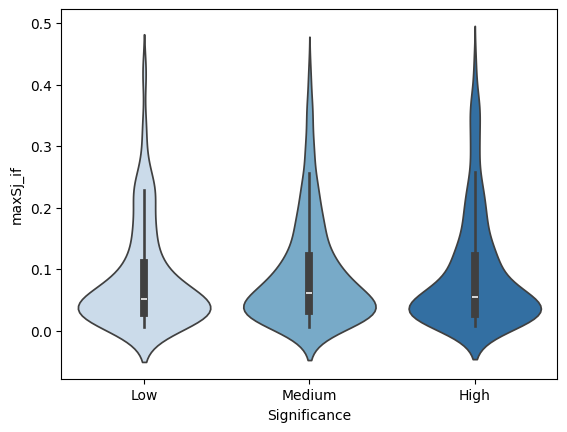

In [35]:
sns.violinplot(x='Significance',y='maxSj_if', hue='Significance', data=mergedData, palette="Blues")

Wow! Those distributions are very similar. As the significance increases, the higher-end tails are thicker, but there are many high-transition-rate states with low maximum Sj.

<Axes: xlabel='Significance', ylabel='njSjMax'>

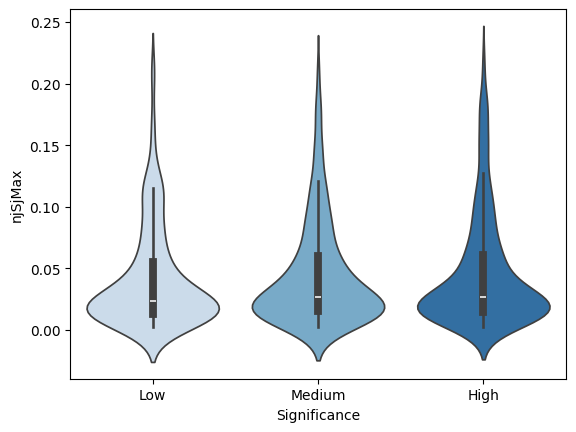

In [36]:
sns.violinplot(x='Significance',y='njSjMax', hue='Significance', data=mergedData, palette="Blues")

<Axes: xlabel='Significance', ylabel='njSjSum'>

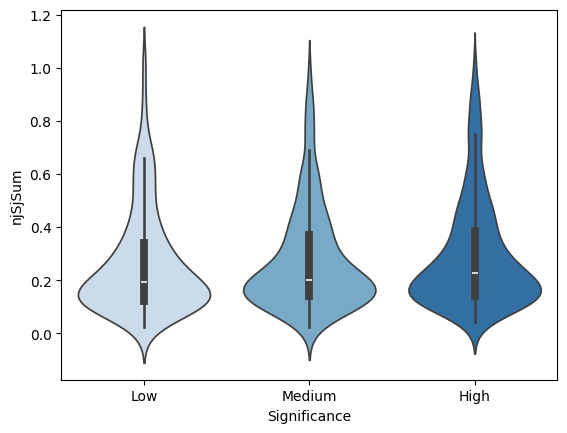

In [37]:
sns.violinplot(x='Significance',y='njSjSum', hue='Significance', data=mergedData, palette="Blues")

<Axes: xlabel='Significance', ylabel='remainder'>

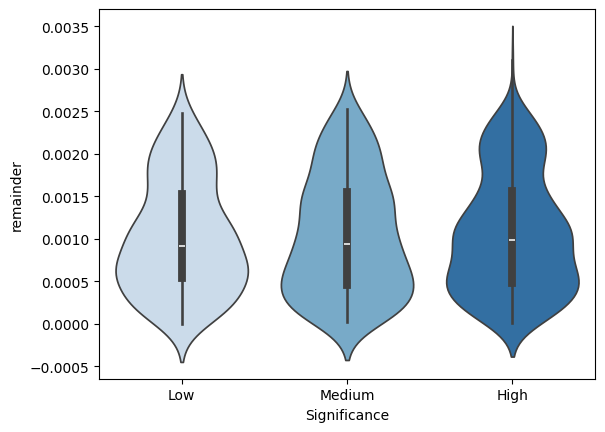

In [38]:
sns.violinplot(x='Significance',y='remainder', hue='Significance', data=mergedData, palette="Blues")

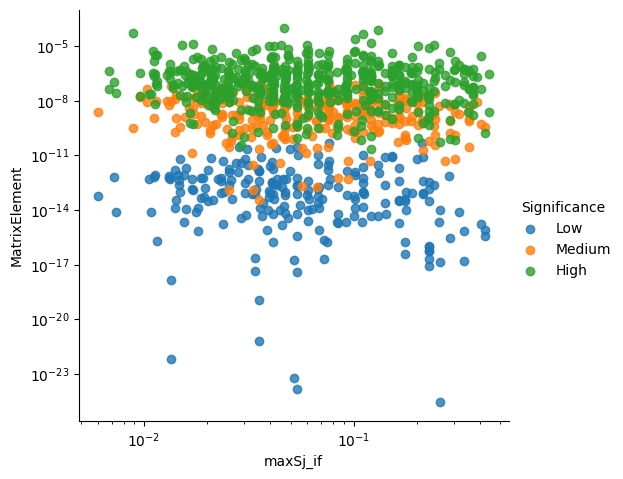

In [39]:
sns.lmplot(x='maxSj_if',y='MatrixElement', data=mergedData,fit_reg=False,hue='Significance')
plt.yscale('log')
plt.xscale('log')
plt.show()

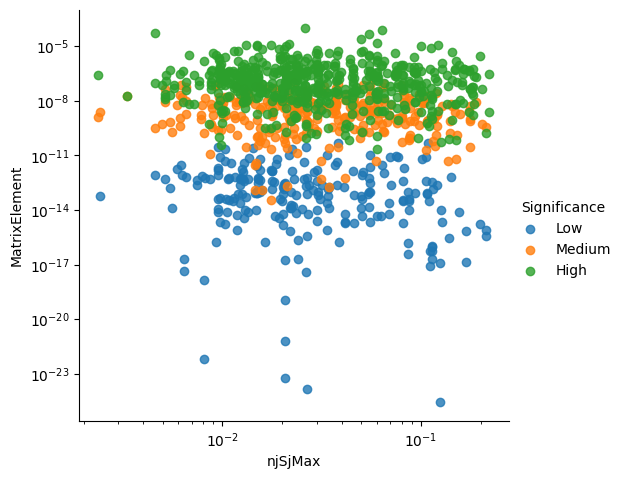

In [40]:
sns.lmplot(x='njSjMax',y='MatrixElement', data=mergedData,fit_reg=False,hue='Significance')
plt.yscale('log')
plt.xscale('log')
plt.show()